In [1]:
import numpy as np
import os
import time
from vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from imagenet_utils import decode_predictions
from keras.layers import Dense, Activation, Flatten
from keras.layers import merge, Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Loading the training data
PATH = os.getcwd()
# Define data path
# data_path = PATH + '/data/hand'
data_path = PATH + '/data/combined'
data_dir_list = [f for f in os.listdir(data_path) if not f.startswith('.')]
img_data_list=[]
# print (data_dir_list)

for dataset in data_dir_list:
	img_list=os.listdir(data_path+'/'+ dataset)
	print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
	for img in img_list:
		if not img.startswith('.'):
			img_path = data_path + '/'+ dataset + '/'+ img
			img = image.load_img(img_path, target_size=(224, 224))
			x = image.img_to_array(img)
			x = np.expand_dims(x, axis=0)
			x = preprocess_input(x)
	#		x = x/255
			# print('Input image shape:', x.shape)
			img_data_list.append(x)

img_data = np.array(img_data_list)
#img_data = img_data.astype('float32')
print (img_data.shape)
img_data=np.rollaxis(img_data,1,0)
print (img_data.shape)
img_data=img_data[0]
print (img_data.shape)


# Define the number of classes
# num_classes = 4
num_classes = 8
num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

# labels[0:770]=0
# labels[770:1738]=1
# labels[1738:2570]=2
# labels[2570:]=3

labels[0:841]=0
labels[841:1643]=1
labels[1643:2345]=2
labels[2345:3095]=3
labels[3095:3836]=4
labels[3836:4774]=5
labels[4774:5506]=6
labels[5506:]=7
# total 6234

# names = ['ok','rock','two','five']

names = ['rock_r', 'five_l', 'ok_r', 'two_l', 'rock_l', 'five_r', 'two_r', 'ok_l']

# convert class labels to on-hot encoding
Y = np_utils.to_categorical(labels, num_classes)

#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)


Loaded the images of dataset-Rock_R

Loaded the images of dataset-Five_L

Loaded the images of dataset-OK_R

Loaded the images of dataset-Two_L

Loaded the images of dataset-Rock_L

Loaded the images of dataset-Five_R

Loaded the images of dataset-Two_R

Loaded the images of dataset-OK_L

(6234, 1, 224, 224, 3)
(1, 6234, 224, 224, 3)
(6234, 224, 224, 3)


In [17]:
#### Training the feature extraction also

image_input = Input(shape=(224, 224, 3))

model = VGG16(input_tensor=image_input, include_top=True,weights='imagenet')

#model.summary()

last_layer = model.get_layer('block5_pool').output
x= Flatten(name='flatten')(last_layer)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(128,activation ='relu',name='fc2')(x)
#x = Dense(128, activation='relu', name='fc2')(x)
out = Dense(num_classes, activation='softmax', name='output')(x)
custom_vgg_model2 = Model(image_input, out)
#custom_vgg_model2.summary()

# freeze all the layers except the dense layers
for layer in custom_vgg_model2.layers[:-3]:
	layer.trainable = False

custom_vgg_model2.summary()

custom_vgg_model2.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

t=time.time()
#	t = now()
hist = custom_vgg_model2.fit(X_train, y_train, batch_size=32, epochs=12, validation_data=(X_test, y_test))
print('Training time: %s' % (t - time.time()))
(loss, accuracy) = custom_vgg_model2.evaluate(X_test, y_test, batch_size=10, verbose=1)

print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

KeyboardInterrupt: 

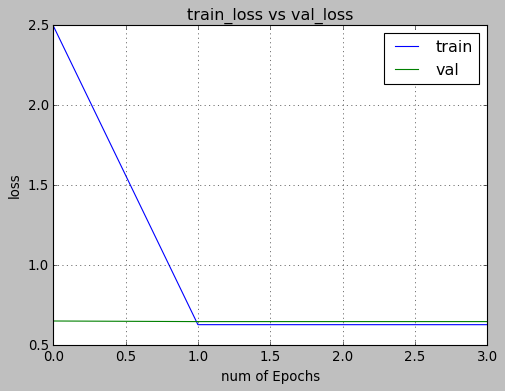

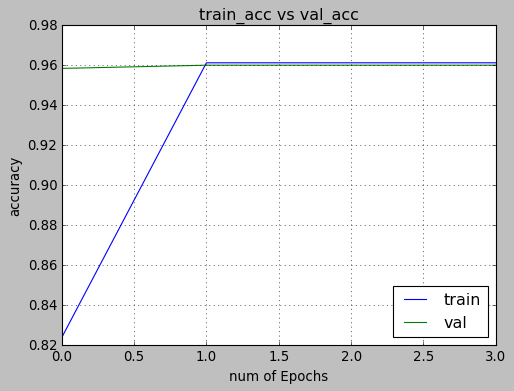

In [11]:
import matplotlib.pyplot as plt
# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=range(12)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])
plt.show()
